In [106]:
import sys

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

import warnings
warnings.filterwarnings('ignore')

In [107]:
method = 'BayesSpace'
pred_key = 'spatial.cluster'
dataset = 'DLPFC'

data_folder = f'../data/{dataset}'
input_dir = f'../Results/results_old/{dataset}/{method}'
output_dir = f'../Results/results_trajectory/{dataset}/{method}'
os.makedirs(output_dir, exist_ok=True)

files = glob.glob(input_dir + '/*')
files = [f for f in files if os.path.isdir(f)]

print(method)
print(files)

BayesSpace
['../Results/results_old/DLPFC/BayesSpace/151669', '../Results/results_old/DLPFC/BayesSpace/151671', '../Results/results_old/DLPFC/BayesSpace/151675', '../Results/results_old/DLPFC/BayesSpace/151672', '../Results/results_old/DLPFC/BayesSpace/151674', '../Results/results_old/DLPFC/BayesSpace/151673', '../Results/results_old/DLPFC/BayesSpace/151670', '../Results/results_old/DLPFC/BayesSpace/151510', '../Results/results_old/DLPFC/BayesSpace/151509', '../Results/results_old/DLPFC/BayesSpace/151507', '../Results/results_old/DLPFC/BayesSpace/151508', '../Results/results_old/DLPFC/BayesSpace/151676']


In [108]:
def process_adata(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    return adata

def plot_trajectory(adata, out_path):
    fix, ax = plt.subplots(figsize=(6, 6))
    sc.tl.paga(adata, groups='pred')
    sc.pl.paga(
        adata, 
        show=False, 
        plot=True,
        fontsize=13,
        ax=ax,
        text_kwds={"color": "#555555"}
    )
    #  Remove plot borders (spines)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    
    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Save the figure
    plt.savefig(os.path.join(out_path, 'trajectory.png'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(out_path, 'trajectory.pdf'), format='pdf', bbox_inches='tight')
    plt.show()

================= Processing BayesSpace DLPFC =================
[1] Processing 151669


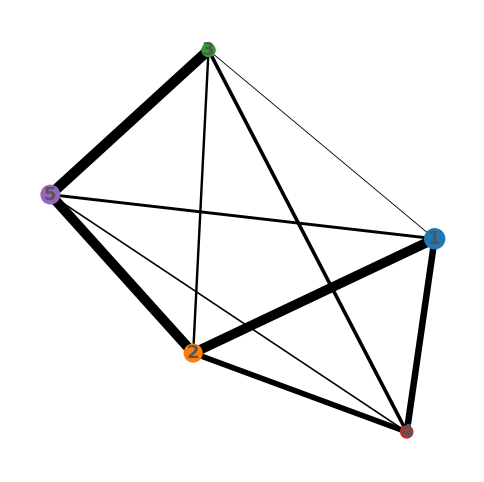

    Results saved to ../Results/results_trajectory/DLPFC/BayesSpace/151669
[2] Processing 151671


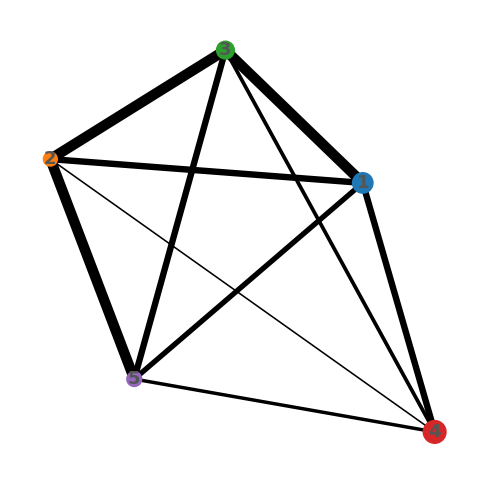

    Results saved to ../Results/results_trajectory/DLPFC/BayesSpace/151671
[3] Processing 151675


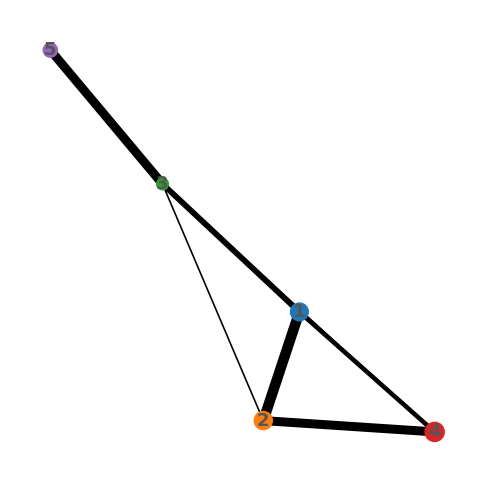

    Results saved to ../Results/results_trajectory/DLPFC/BayesSpace/151675
[4] Processing 151672


KeyboardInterrupt: 

In [109]:
print(f'================= Processing {method} {dataset} =================')
metrics_list = []
for i, file in enumerate(files):
    section_id = file.split('/')[-1]
    out_path = os.path.join(output_dir, section_id)
    os.makedirs(out_path, exist_ok=True)
    
    print(f'[{i + 1}] Processing {section_id}')

    file_path = os.path.join(data_folder, section_id)

    adata = sc.read_visium(file_path, count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique()
    metadata = pd.read_csv(file + '/cell_metadata.csv', index_col=0)
    gt_metadata = pd.read_csv(os.path.join(file_path, 'metadata.tsv'), sep='\t')

    adata.obs['gt'] = gt_metadata['layer_guess'].values
    adata = adata[~pd.isnull(adata.obs['gt'])]
    # adata = adata[adata.obs.index.isin(metadata.index)]
    metadata = metadata.loc[adata.obs.index]
    gt_metadata = gt_metadata.loc[adata.obs.index]
    pred = metadata[pred_key].values
    if min(pred) == 0:
        pred += 1

    adata.obs['gt'] = adata.obs['gt'].astype(str)
    adata.obs['pred'] = pred.astype(str)

    adata = process_adata(adata)
    plot_trajectory(adata, out_path)
    print(f'    Results saved to {out_path}')
    # break

print(f'================= Finished {method} {dataset} =================')
# print(df_metrics)